In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


# 1. Загружаем данные и анализируем датасет

In [2]:
# зафиксировал random seed и версию пакетов, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
!pip freeze > requirements.txt

# Подгружаем данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') 

In [3]:
df_train['sample'] = 1           # помечаем где у нас трейн
df_test['sample'] = 0            # помечаем где у нас тест
df_test['reviewer_score'] = 0    # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train 

    Признаки:
    
    hotel_address - адрес отеля
    review_date - дата, когда рецензент разместил соответствующий отзыв.
    average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
    hotel_name - название отеля
    reviewer_nationality - национальность рецензента
    negative_review - отрицательный отзыв, который рецензент дал отелю.
    review_total_negative_word_counts - общее количество слов в отрицательном отзыв
    positive_review - положительный отзыв, который рецензент дал отелю
    review_total_positive_word_counts - общее количество слов в положительном отзыве
    reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
    total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
    total_number_of_reviews - общее количество действительных отзывов об отеле
    tags - теги, которые рецензент дал отелю.
    days_since_review - продолжительность между датой проверки и датой очистки
    additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
    lat - широта отеля
    lng - долгота отеля

In [4]:
# проверяем датасет на наличие строковых данных
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [5]:
# для предварительного анализа датасета можем использовать Pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(hotels, title="Booking_hotels")
profile

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Из этих данных можем сделать следующие выводы:
всего 515738 строк, пропусков - 6536, пропуски в данных lat и lng, 336 дубликатов
9 категориальных и 9 числовых признаков
большая часть рецензентов из UK, на втором месте USA
между признаками total_number_of_reviews и additional_number_of_scoring достаточно сильная корреляция

# 2. Очистка и обработка датасета

# 2.1 Работа с адресами отелей

Я хотела поработать с адресом отеля и выделить такие признаки как страна и город

In [6]:
# выделяем отдельный датасет для признаков, которые относятся к отелям и присваиваем индекс каждому отелю
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring']

# удаляем дубликаты данных
only_hotels = hotels[hotel_cols].drop_duplicates().reset_index(drop=True)
only_hotels['hotel_id'] = only_hotels.index

In [7]:
only_hotels.head()

hotel_name  \
0                              Hotel Da Vinci   
1                           Urban Lodge Hotel   
2  Alexandra Barcelona A DoubleTree by Hilton   
3                    Hotel Principe Di Savoia   
4                              Hotel Esther a   

                                       hotel_address        lat       lng  \
0                 Via Senigallia 6 20161 Milan Italy  45.533137  9.171102   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...  52.385649  4.834443   
2        Mallorca 251 Eixample 08008 Barcelona Spain  41.393192  2.161520   
3  Piazza Della Repubblica 17 Central Station 201...  45.479888  9.196298   
4  Singel 303 309 Amsterdam City Center 1012 WJ A...  52.370545  4.888644   

   average_score  total_number_of_reviews  additional_number_of_scoring  \
0            8.1                    16670                           904   
1            8.6                     5018                           612   
2            8.3                      351                            46   
3            9.1                     1543                           241   
4            9.1                     4687                           834   

   hotel_id  
0         0  
1         1  
2         2  
3         3  
4         4

In [8]:
# из основного датасета удалим признаки, которые относятся к отелю, и добавим id. Потом будем отдельно добавлять нужные признаки 
hotels = hotels.merge(only_hotels, on=hotel_cols, how='left')
hotels = hotels.drop(hotel_cols, axis=1)

In [9]:
# Выделяем страну, город и почтовый индекс из адреса отеля
# Изначально хотела остановиться только на стране и городе, а пропуски заполнить модами, но это не совсем корректный подход
only_hotels['city'] = only_hotels.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
only_hotels['country'] = only_hotels.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
only_hotels['zip'] = only_hotels.hotel_address.apply(lambda x: x.split()[-4]+' '+x.split()[-3] if x.endswith('United Kingdom') or x.endswith('Netherlands') else x.split()[-3])

In [10]:
# Обратим внимание, что уникальных значений городов и стран всего 6, причем каждому значению страны соответствует только одно значение города
display(only_hotels['city'].unique())
display(only_hotels['country'].unique())

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

In [11]:
# признаки с численностью населения страны и города отеля
# данные беру из https://ru.wikipedia.org/wiki/
сity_population = {
    'Milan': 1399860, 'Amsterdam': 872757,
    'Barcelona': 1664182, 'London': 8961989,
    'Paris': 2148327, 'Vienna': 1921153
}
only_hotels['сity_population'] = only_hotels['city'].map(сity_population)
country_population = {
    'Italy': 59257566, 'Netherlands': 17441500,
    'Spain': 47363419, 'United Kingdom': 67081000,
    'France': 64844037, 'Austria': 8916864
}
only_hotels['country_population'] = only_hotels['country'].map(country_population)
only_hotels['%_city_pop_from_country_pop'] = only_hotels['сity_population'] / only_hotels['country_population']

In [12]:
# получим карту распределения отелей по странам
import plotly.express as px

hotel_country = only_hotels.groupby('country')['hotel_name'].count()
fig = px.choropleth(
    locations=hotel_country.index,
    locationmode = "country names",
    scope='europe',
    color=np.log(hotel_country.values),
    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

Из графика видно, что большинство отелей расположено во Франции, на втором месте UK. Поскольку каждой стране соответствует только один город, можно сказать, что большинство отелей расположено в Париже, в дальнейшем я планирую удалить признак страны, поскольку по сути признак города и страны однои тоже

In [13]:
# распределение гостей по странам
df_nationality = pd.DataFrame(hotels['reviewer_nationality'].value_counts())
fig = px.choropleth(
    locations = df_nationality.index,
    locationmode = 'country names',
    color = np.log(df_nationality['reviewer_nationality']),
    color_continuous_scale=px.colors.sequential.Plasma
)

fig.show()

Как уже отмечалось выше, большинство людей, оставляющих отзывы, живут в UK. К национальности я вернусь ниже, когда закодирую признак города и соединю разрозненные датасеты

Я отказалась от затеи ниже, поскольку все таки заполнение модами географические данные не совсем корректно

In [14]:
# Просто оставлю
# Заполняем пропуски модами и проверяем, остались ли нулевые значения
#values = {
#    'lat':only_hotels['lat'].mode()[0],
#    'lng':only_hotels['lng'].mode()[0]
#}

#only_hotels.fillna(values, inplace=True)
#only_hotels.isnull().mean()

In [15]:
#Будем считать среднюю географическую координату для заполнения пропусков
geography = only_hotels.groupby(['city', 'zip']).agg({'lat' : 'mean', 'lng' : 'mean'})
only_hotels = only_hotels.merge(geography, on=['city', 'zip'], suffixes=('', '_avg'))

only_hotels[only_hotels.lat.isna()]

hotel_name  \
199                                      Hotel Atlanta   
200                          City Hotel Deutschmeister   
205                 Hotel Pension Baron am Schottentor   
267                                      Hotel Advance   
333             Maison Albar Hotel Paris Op ra Diamond   
437                                Hotel Daniel Vienna   
573                    Mercure Paris Gare Montparnasse   
702                        Renaissance Barcelona Hotel   
758                     NH Collection Barcelona Podium   
826                                       Roomz Vienna   
863                       Holiday Inn Paris Montmartre   
1012                                Hotel City Central   
1100               Fleming s Selection Hotel Wien City   
1102                         Cordial Theaterhotel Wien   
1405      Derag Livinghotel Kaiser Franz Joseph Vienna   
1406                                  Hotel Park Villa   
1407  Austria Trend Hotel Schloss Wilhelminenberg Wien   

                                          hotel_address  lat  lng  \
199   W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  NaN  NaN   
200   Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  NaN  NaN   
205   W hringer Stra e 12 09 Alsergrund 1090 Vienna ...  NaN  NaN   
267        Sep lveda 180 Eixample 08011 Barcelona Spain  NaN  NaN   
333    4 rue de la P pini re 8th arr 75008 Paris France  NaN  NaN   
437   Landstra er G rtel 5 03 Landstra e 1030 Vienna...  NaN  NaN   
573       20 Rue De La Ga t 14th arr 75014 Paris France  NaN  NaN   
702       Pau Clar s 122 Eixample 08009 Barcelona Spain  NaN  NaN   
758           Bail n 4 6 Eixample 08010 Barcelona Spain  NaN  NaN   
826    Paragonstra e 1 11 Simmering 1110 Vienna Austria  NaN  NaN   
863        23 Rue Damr mont 18th arr 75018 Paris France  NaN  NaN   
1012  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  NaN  NaN   
1100  Josefst dter Stra e 10 12 08 Josefstadt 1080 V...  NaN  NaN   
1102  Josefst dter Stra e 22 08 Josefstadt 1080 Vien...  NaN  NaN   
1405  Sieveringer Stra e 4 19 D bling 1190 Vienna Au...  NaN  NaN   
1406  Hasenauerstra e 12 19 D bling 1190 Vienna Austria  NaN  NaN   
1407   Savoyenstra e 2 16 Ottakring 1160 Vienna Austria  NaN  NaN   

      average_score  total_number_of_reviews  additional_number_of_scoring  \
199             7.8                     2724                           214   
200             8.0                      675                            44   
205             8.0                     1315                           122   
267             8.3                      156                            18   
333             8.8                     1524                           172   
437             8.5                     1405                           101   
573             7.8                      377                            22   
702             7.6                      104                            20   
758             8.9                      883                            96   
826             8.1                      568                            36   
863             8.3                      298                            21   
1012            8.6                     2923                           211   
1100            8.3                     3672                           333   
1102            8.4                      422                            39   
1405            8.0                     1496                           115   
1406            8.6                      564                            37   
1407            8.3                     1558                            86   

      hotel_id       city  country    zip  сity_population  \
199         35     Vienna  Austria   1090          1921153   
200        343     Vienna  Austria   1090          1921153   
205       1009     Vienna  Austria   1090          1921153   
267       1484  Barcelona    Spain  08011          1664182   
333        924      Paris   France  75008

In [16]:
# Будем заменять пропуски в географических данных, исходя из индексов
only_hotels['lat'] = np.where(only_hotels.lat.isna(), only_hotels.lat_avg, only_hotels.lat)
only_hotels['lng'] = np.where(only_hotels.lng.isna(), only_hotels.lng_avg, only_hotels.lng)
only_hotels = only_hotels.drop(['lat_avg', 'lng_avg'], axis=1)

In [17]:
# Проверяем, остались ли пропуски
only_hotels.isnull().mean()

hotel_name                      0.0
hotel_address                   0.0
lat                             0.0
lng                             0.0
average_score                   0.0
total_number_of_reviews         0.0
additional_number_of_scoring    0.0
hotel_id                        0.0
city                            0.0
country                         0.0
zip                             0.0
сity_population                 0.0
country_population              0.0
%_city_pop_from_country_pop     0.0
dtype: float64

In [18]:
# соединяем назад наши датасеты
hotels = hotels.merge(only_hotels, on='hotel_id', how='left')

# кодируем город и индекс с помощью  метода LabelEncode
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
hotels['city'] = LabelEncoder().fit_transform(hotels['city'])
hotels['zip'] = LabelEncoder().fit_transform(hotels['zip'])

hotels.head()

review_date        reviewer_nationality  \
0   7/21/2017             United Kingdom    
1  12/12/2016                    Belgium    
2  11/26/2015                     Sweden    
3  10/17/2015   United States of America    
4   5/16/2016             United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   
4                                        No Negative   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   
2                                  3   
3                                  0   
4                                  0   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...           656 day   
4  [' Business trip ', ' Solo traveler ', ' Class...           444 day   

   sample  ...       lng  average_score total_number_of_reviews  \
0       0  ...  9.171102            8.1                   16670   
1       0  ...  4.834443            8.6                    5018   
2       0  ...  2.161520            8.3                     351   
3       0  ...  9.196298            9.1                    1543   
4       0  ...  4.888644            9.1                    4687   

  additional_number_of_scoring  city      country  zip  сity_population  \
0                          904     3        Italy  187          1399860   
1                          612     0  Netherlands   87           872757   
2                           46     1        Spain    7          1664182   
3                          241     3        Italy  158          1399860   
4                          834     0  Netherlands   52           872757   

   country_population  %_city_pop_from_country_pop  
0            59257566                     0.023623  
1            17441500                     0.050039  
2            47363419                     0.035136  
3            59257566                     0.023623  
4            17441500                     0.050039  

[5 rows x 25 columns]

Теперь подробнее займемся национальностью обзорщиков, построю тепловою карту, причем пока небу исключать никакие национальности

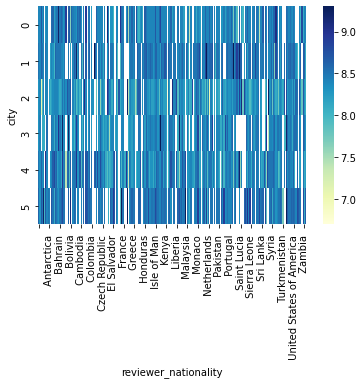

In [19]:
import seaborn as sns
table = pd.pivot_table(hotels,
               index='city',
               values='average_score',
               columns='reviewer_nationality',
               aggfunc = 'median') 

heatmap = sns.heatmap(data=table, cmap='YlGnBu')

In [20]:
# Проверю, сколько всего уникальных признаков национальности
# поскольку по тепловой карте сложно что-то понять
len(hotels['reviewer_nationality'].unique())

227

In [21]:
# Оставлю только 10 наиболее активных национальностей
most_active_nationalities= hotels['reviewer_nationality'].value_counts().nlargest(10).index
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x:x if x in most_active_nationalities else 'Other')

hotels.head(5)

review_date        reviewer_nationality  \
0   7/21/2017             United Kingdom    
1  12/12/2016                       Other   
2  11/26/2015                       Other   
3  10/17/2015   United States of America    
4   5/16/2016             United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   
4                                        No Negative   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   
2                                  3   
3                                  0   
4                                  0   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...           656 day   
4  [' Business trip ', ' Solo traveler ', ' Class...           444 day   

   sample  ...       lng  average_score total_number_of_reviews  \
0       0  ...  9.171102            8.1                   16670   
1       0  ...  4.834443            8.6                    5018   
2       0  ...  2.161520            8.3                     351   
3       0  ...  9.196298            9.1                    1543   
4       0  ...  4.888644            9.1                    4687   

  additional_number_of_scoring  city      country  zip  сity_population  \
0                          904     3        Italy  187          1399860   
1                          612     0  Netherlands   87           872757   
2                           46     1        Spain    7          1664182   
3                          241     3        Italy  158          1399860   
4                          834     0  Netherlands   52           872757   

   country_population  %_city_pop_from_country_pop  
0            59257566                     0.023623  
1            17441500                     0.050039  
2            47363419                     0.035136  
3            59257566                     0.023623  
4            17441500                     0.050039  

[5 rows x 25 columns]

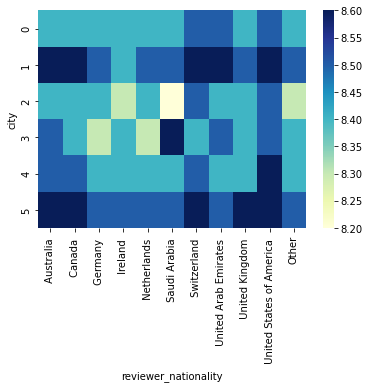

In [22]:
# Теперь построю тепловую карту заново
table = pd.pivot_table(hotels,
               index='city',
               values='average_score',
               columns='reviewer_nationality',
               aggfunc = 'median') 

heatmap = sns.heatmap(data=table, cmap='YlGnBu')

Не уверена, что этот признак как-нибудь будет влиять н датасет, но я его оставлю и закодирую

In [23]:
hotels['reviewer_nationality'] = LabelEncoder().fit_transform(hotels['reviewer_nationality'])
hotels.head(5)

review_date  reviewer_nationality  \
0   7/21/2017                     8   
1  12/12/2016                    10   
2  11/26/2015                    10   
3  10/17/2015                     9   
4   5/16/2016                     8   

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   
4                                        No Negative   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   
2                                  3   
3                                  0   
4                                  0   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...           656 day   
4  [' Business trip ', ' Solo traveler ', ' Class...           444 day   

   sample  ...       lng  average_score total_number_of_reviews  \
0       0  ...  9.171102            8.1                   16670   
1       0  ...  4.834443            8.6                    5018   
2       0  ...  2.161520            8.3                     351   
3       0  ...  9.196298            9.1                    1543   
4       0  ...  4.888644            9.1                    4687   

  additional_number_of_scoring  city      country  zip  сity_population  \
0                          904     3        Italy  187          1399860   
1                          612     0  Netherlands   87           872757   
2                           46     1        Spain    7          1664182   
3                          241     3        Italy  158          1399860   
4                          834     0  Netherlands   52           872757   

   country_population  %_city_pop_from_country_pop  
0            59257566                     0.023623  
1            17441500                     0.050039  
2            47363419                     0.035136  
3            59257566                     0.023623  
4            17441500                     0.050039  

[5 rows x 25 columns]

# 2.2 Работа с датами отзывов

In [24]:
# переводим нужную нам информацию в формат datatime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

# Посмотрим на даты оставления последнего и первого отзывов
print('Дата оставления самого свежего отзыва:', hotels['review_date'].max())
print('Дата оставления самого первого отзыва:', hotels['review_date'].min())

Дата оставления самого свежего отзыва: 2017-08-03 00:00:00
Дата оставления самого первого отзыва: 2015-08-04 00:00:00


In [25]:
# Работаем с датой отзыва
# Разделяем один признак на несколько, чтобы проанализировать, зависит ли отзыв от месяца/времени года или дня недели
hotels['day'] = hotels['review_date'].dt.day.astype(int)
hotels['month'] = hotels['review_date'].dt.month.astype(int)
hotels['year'] = hotels['review_date'].dt.year.astype(int)

hotels['day_of_week'] = hotels['review_date'].dt.dayofweek.astype(int)
hotels['is_weekend'] = hotels['day'].apply(lambda x: 1 if x>4 else 0)

hotels['is_spring'] = hotels['month'].apply(lambda x: 1 if x in [3,4,5] else 0)
hotels['is_summer'] = hotels['month'].apply(lambda x: 1 if x in [6,7,8] else 0)
hotels['is_autumn'] = hotels['month'].apply(lambda x: 1 if x in [9,10,11] else 0)
hotels['is_winter'] = hotels['month'].apply(lambda x: 1 if x in [12,1,2] else 0)

hotels.drop(['review_date'], inplace=True, axis=1)

def since_review_func(x):
    string = str(x)
    return string.split()[0]
hotels['days_since_review'] = hotels['days_since_review'].apply(since_review_func)

hotels.head(5)

reviewer_nationality                                    negative_review  \
0                     8   Would have appreciated a shop in the hotel th...   
1                    10        No tissue paper box was present at the room   
2                    10                                           Pillows    
3                     9                                        No Negative   
4                     8                                        No Negative   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   
2                                  3   
3                                  0   
4                                  0   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...                13   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...               234   
2  [' Business trip ', ' Solo traveler ', ' Twin ...               616   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...               656   
4  [' Business trip ', ' Solo traveler ', ' Class...               444   

   sample  reviewer_score  ...  %_city_pop_from_country_pop day month  year  \
0       0             0.0  ...                     0.023623  21     7  2017   
1       0             0.0  ...                     0.050039  12    12  2016   
2       0             0.0  ...                     0.035136  26    11  2015   
3       0             0.0  ...                     0.023623  17    10  2015   
4       0             0.0  ...                     0.050039  16     5  2016   

   day_of_week  is_weekend  is_spring  is_summer  is_autumn is_winter  
0            4           1          0          1          0         0  
1            0           1          0          0          0         1  
2            3           1          0          0          1         0  
3            5           1          0          0          1         0  
4            0           1          1          0          0         0  

[5 rows x 33 columns]

In [26]:
calendar = pd.pivot_table(
    data=hotels,
    index='month',
    values='reviewer_score',
    columns='day',
    aggfunc='median')

fig = px.imshow(calendar)
fig.show()


На диаграмме видно, что зимой и весной оценки выше (1-3 месяцы), а вот осенью оценки ниже (10-11 месяцы)

# 2.3 Работа с отзывами

Из нечисловых данных остались только три признака, все они относятся непосредственно к обзору на отель.

In [27]:
hotels.head(5)

reviewer_nationality                                    negative_review  \
0                     8   Would have appreciated a shop in the hotel th...   
1                    10        No tissue paper box was present at the room   
2                    10                                           Pillows    
3                     9                                        No Negative   
4                     8                                        No Negative   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   
2                                  3   
3                                  0   
4                                  0   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...                13   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...               234   
2  [' Business trip ', ' Solo traveler ', ' Twin ...               616   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...               656   
4  [' Business trip ', ' Solo traveler ', ' Class...               444   

   sample  reviewer_score  ...  %_city_pop_from_country_pop day month  year  \
0       0             0.0  ...                     0.023623  21     7  2017   
1       0             0.0  ...                     0.050039  12    12  2016   
2       0             0.0  ...                     0.035136  26    11  2015   
3       0             0.0  ...                     0.023623  17    10  2015   
4       0             0.0  ...                     0.050039  16     5  2016   

   day_of_week  is_weekend  is_spring  is_summer  is_autumn is_winter  
0            4           1          0          1          0         0  
1            0           1          0          0          0         1  
2            3           1          0          0          1         0  
3            5           1          0          0          1         0  
4            0           1          1          0          0         0  

[5 rows x 33 columns]

Можно отметить, что часто появляются такие отзывы, как "No Negative" и "No Positive". В данном контексте эти словосочетания можно итерпретировать в обратном смысле. 

In [28]:
hotels['no_neg'] = 0
hotels['no_pos'] = 0

no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 'liked everything',
              'can t think of anything', 'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 'nothing to complain about', 'non']

hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

hotels['negative_review'].value_counts()[:10]

                158085
 Breakfast         407
 Small room        373
 Location          368
 Everything        326
 Price             260
 Small rooms       188
 Expensive         142
 Room size         140
 Staff             130
Name: negative_review, dtype: int64

In [29]:
no_pos_list = ['no positive', 'nothing']

hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1

hotels['positive_review'].value_counts()[:10]

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

In [30]:
hotels['neg_len'] = hotels['negative_review'].map(len)
hotels['pos_len'] = hotels['positive_review'].map(len)

Займемся анализом тональности текста (https://habr.com/ru/post/149605/)
Я пыталась несколько раз использовать следующий метод https://habr.com/ru/post/517410/ , но ноутбук постоянно вис, поэтому я не смогла это реализовать

In [31]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

analyz = SentimentIntensityAnalyzer()

# проводим анализ текста с помощью SentimentIntensityAnalyzer()
hotels['review_neg'] = hotels['negative_review'].apply(lambda x: analyz.polarity_scores(x))
hotels['review_pos'] = hotels['positive_review'].apply(lambda x: analyz.polarity_scores(x))

# результаты помещаем в hotels
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(hotels['review_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(hotels['review_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

hotels.head(5)

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


reviewer_nationality                                    negative_review  \
0                     8   Would have appreciated a shop in the hotel th...   
1                    10        No tissue paper box was present at the room   
2                    10                                           Pillows    
3                     9                                                      
4                     8                                                      

   review_total_negative_word_counts  \
0                                 52   
1                                 10   
2                                  3   
3                                  0   
4                                  0   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...                13   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...               234   
2  [' Business trip ', ' Solo traveler ', ' Twin ...               616   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...               656   
4  [' Business trip ', ' Solo traveler ', ' Class...               444   

   sample  reviewer_score  ...  \
0       0             0.0  ...   
1       0             0.0  ...   
2       0             0.0  ...   
3       0             0.0  ...   
4       0             0.0  ...   

                                          review_neg  \
0  {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...   
1  {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
3  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   
4  {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...   

                                          review_pos  n_neg  n_neu  n_pos  \
0  {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...  0.129  0.747  0.125   
1  {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...  0.216  0.784  0.000   
2  {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...  0.000  1.000  0.000   
3  {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...  0.000  0.000  0.000   
4  {'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...  0.000  0.000  0.000   

   n_compound  p_neg  p_neu  p_pos p_compound  
0     -0.0554  0.000  0.671  0.329     0.9615  
1     -0.2960  0.379  0.000  0.621     0.3400  
2      0.0000  0.000  0.260  0.740     0.6908  
3      0.0000  0.000  0.621  0.379     0.9153  
4      0.0000  0.000  0.230  0.770     0.7717  

[5 rows x 47 columns]

In [32]:
hotels['%_positive_words_in_review'] = hotels['review_total_positive_word_counts'] / \
     (hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts'])
hotels['%_negative_words_in_review'] = hotels['review_total_negative_word_counts'] / \
     (hotels['review_total_positive_word_counts'] + hotels['review_total_negative_word_counts'])

hotels['#_positive_words_per_review'] = hotels['review_total_positive_word_counts'] / \
     hotels['total_number_of_reviews_reviewer_has_given']
hotels['#_negative_words_per_review'] = hotels['review_total_negative_word_counts'] / \
     hotels['total_number_of_reviews_reviewer_has_given']

In [33]:
# убираем все лишнее, т.е. данные типа object и признак zip

object_columns = [strings for strings in hotels.columns if hotels[strings].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)
hotels.drop(['zip'], axis = 1, inplace=True)
hotels.drop(['hotel_id'], axis = 1, inplace=True)

hotels = hotels.fillna(0)
print(hotels.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   reviewer_nationality                        515738 non-null  int64  
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   sample                                      515738 non-null  int64  
 5   reviewer_score                              515738 non-null  float64
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   average_score                               515738 non-null  float64
 9   total_number_of_reviews                     515738 non-null  int64  
 

<AxesSubplot:>

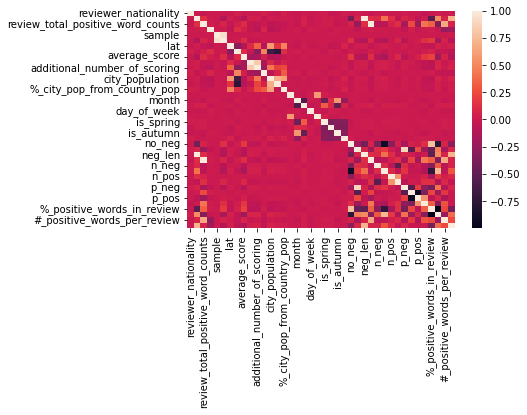

In [34]:
# проверим, нужно ли еще что-то удалять
sns.heatmap(hotels.corr())

Очень много признаков, на тепловой диаграмме толком ничего не видно

# 3. Нормализуем данные

In [35]:
# числовые признаки
num_cols = ['review_total_negative_word_counts', 
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given',
            'total_number_of_reviews', 'reviewer_score',
            'additional_number_of_scoring',
            'сity_population', 'country_population',
            '%_city_pop_from_country_pop',
            'neg_len', 'pos_len',
            'n_neu', 'n_pos','n_neg',
            'n_compound','p_compound',
            'p_neg', 'p_neu', 'p_pos',
            '%_positive_words_in_review', '%_negative_words_in_review',
            '#_positive_words_per_review', '#_negative_words_per_review'
            ]

# категориальные признаки
cat_cols = ['reviewer_nationality',
            'lat', 'lng',
            'city','day',
            'month', 'year', 
            'day_of_week', 'is_weekend',
            'is_spring', 'is_summer',
            'is_autumn', 'is_winter',
            'no_neg', 'no_pos',    
            'average_score',           
            ]         

<AxesSubplot:>

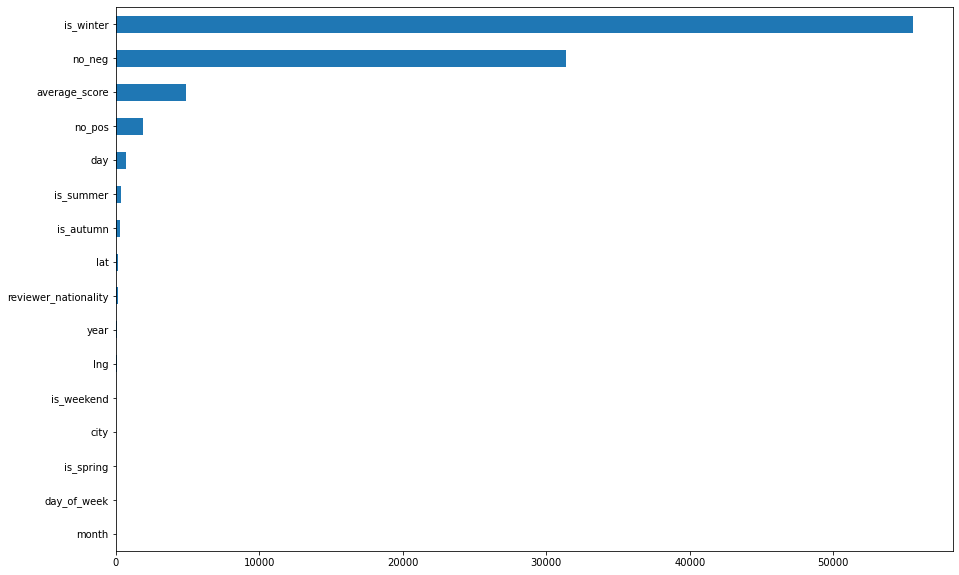

In [36]:
from sklearn.feature_selection import chi2 # хи-квадрат
import matplotlib.pyplot as plt
%matplotlib inline

# Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат.
# Выведем значения хи-квадрат на графике:

y = hotels.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = hotels.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min()
X = X.drop(['lng'], axis=1)

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

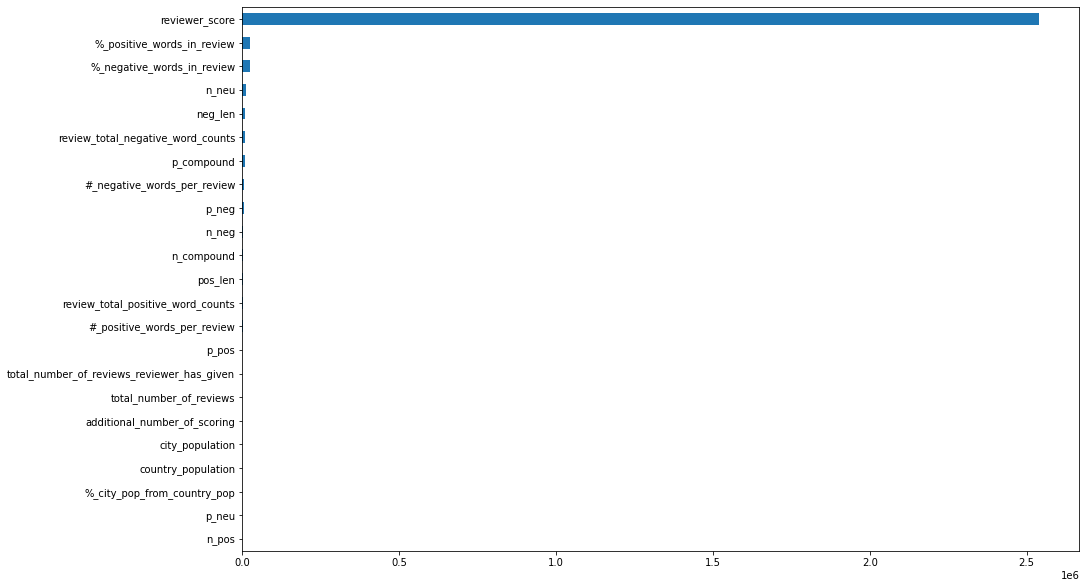

In [37]:
from sklearn.feature_selection import f_classif # anova
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.
# В основе метода оценки значимости переменных лежит анализ (ANOVA).
# В качестве меры значимости будем использовать значение f-статистики - чем значение статистики выше, тем меньше 
# вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

y = hotels.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = hotels.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [38]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующий с другим признаком
pivot = hotels.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)
fig.show()

# постараемся удалить как можно меньше признаков. Сначала удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = hotels.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

Deleted 9 columns


# 4. Обучение модели

In [39]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [40]:
# Разделяем тренинговый датасет: 80% на обучение, 20% на валидацию
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [41]:
# проверяем размерности получившихся датасетов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386803, 38), (386803, 37), (309442, 37), (77361, 37))

In [42]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [43]:
# Обучаем модель
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [44]:
# Пишем свою функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [45]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8626931141014204
MAPE: 12.240862661868299


<AxesSubplot:>

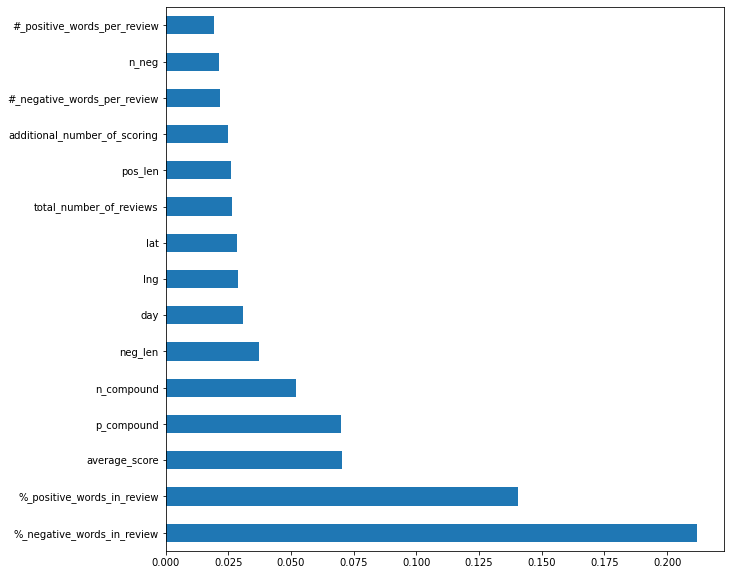

In [46]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [47]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [48]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.6s finished


In [49]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.762  488440
1           7.493  274649
2           8.237  374688
3           9.723  404352
4           9.622  451596
5           9.341  302161
6           7.381  317079
7           7.803   13963
8           8.696  159785
9           7.485  195089